# Abstract:

Application de traitements d'images et utilisation de CNN afin de réaliser la classification de quelques espèces de primates. Plusieurs essais sont présentés:
- Generator avec augmentation de donnée
- Augmentation de donnée via fonctions dédiées à partir des dataframes
- Entrainement sur données originelles et données augmentées

# Table: <a class="anchor" id="chapter0"></a>

* [Bibliothèques utilisées](#chapter1)
* [Setup & exploration](#chapter2)
* [Dataviz](#chapter3)
* [Essai traitement d'image](#chapter4)
* [Setup du modèle](#chapter8)
* [Modèle convolutif avec generator et augmentation de donnée](#chapter5)
* [Modèle convolutif sans generator](#chapter6)
* [Modèle convolutif avec augmentation de donnée sur dataframe](#chapter7)
    * [Augmentation de donnée](#section_7_1)
    * [Modèle](#section_7_2)

# -----------------------------------------------------------------------------------------------------------

### Bibliothèqes utilisées <a class="anchor" id="chapter1"></a>

* [retour Table](#chapter0)

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pour l'exploitation d'image
import matplotlib.image as img
from PIL import Image
from skimage import io, color, exposure, transform
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import data, io, filters
from skimage import *
from skimage.transform import resize
from scipy import ndimage

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Réduction de dimension
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Prépa données
from sklearn.model_selection import train_test_split

# Clustering
from scipy.cluster.hierarchy  import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


# DL
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Deconv2D
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations

# generator
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Evaluation
from sklearn.metrics import confusion_matrix

# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random


# -----------------------------------------------------------------------------------------------------------

### Setup & exploration <a class="anchor" id="chapter2"></a>


* [retour Table](#chapter0)

In [2]:
# On renseigne le path du dossier contenant les images du set training et du set validation
path = 'D:\BAZAR-Lolo\singes'

# On stocke dans une liste l'ensemble des chemins
fichiers =[]    
for root,dirs,files in os.walk(path):
    for fichier in files:
        fichiers.append(os.path.join(root,fichier))

# On renseigne les path dans un dataframe
df = pd.DataFrame(fichiers[1:],columns =['path'])

# On rajoute une variable indiquant le label
df['label']=df.path.swifter.apply(lambda x: str(x.split("\\")[5][1]))

# On rajoute la variable indiquant le nom du fichier
df['id'] = df.path.swifter.apply(lambda x : x.split('\\')[6].split('.')[0])

# On rajoute une variable indiquant si l'entrée en question relève du répertoire validation / train
df['jeu'] = df.path.swifter.apply(lambda x : 'training' if 'training' in x else 'validation')

# On rajoute deux variables renseignant sur la hauteur et la largeur des images
df['hauteur'] = df.path.swifter.apply(lambda x: np.asarray(Image.open(x)).shape[0])
df['largeur'] = df.path.swifter.apply(lambda x: np.asarray(Image.open(x)).shape[1])

# On rajoute une variable renseignant sur la taille des images
df['taille'] = df.path.swifter.apply(lambda x : Path(x).stat().st_size)

# On affiche les premières lignes
df.head()

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

,path,label,id,jeu,hauteur,largeur,taille
0,D:\BAZAR-Lolo\singes\training\training\n0\n001...,0,n0018,training,367,550,38525
1,D:\BAZAR-Lolo\singes\training\training\n0\n001...,0,n0019,training,1080,1920,219701
2,D:\BAZAR-Lolo\singes\training\training\n0\n002...,0,n0020,training,450,337,53734
3,D:\BAZAR-Lolo\singes\training\training\n0\n002...,0,n0021,training,2911,4367,9072692
4,D:\BAZAR-Lolo\singes\training\training\n0\n002...,0,n0022,training,1900,1526,993829


# -----------------------------------------------------------------------------------------------------------

### Dataviz <a class="anchor" id="chapter3"></a>

* [retour Table](#chapter0)

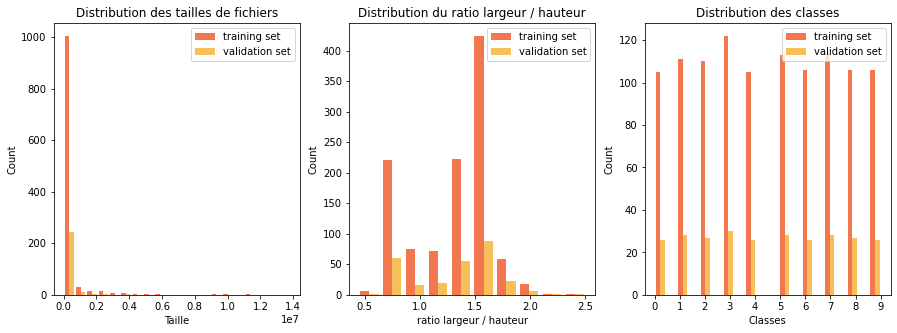

In [3]:
# On affiche la distribution des tailles de fichiers, ratio largeur/hauteur et classes
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist([df[df['jeu']=='training'].taille,df[df['jeu']=='validation'].taille],bins = 20,color =['#f27750','#f7bf59'],
        label = ['training set','validation set'])
plt.ylabel('Count')
plt.xlabel('Taille')
plt.title('Distribution des tailles de fichiers')
plt.legend()

plt.subplot(1,3,2)
plt.hist([df[df['jeu']=='training'].largeur /df[df['jeu']=='training'].hauteur ,df[df['jeu']=='validation'].largeur /df[df['jeu']=='validation'].hauteur],bins = 10,color =['#f27750','#f7bf59'],
        label = ['training set','validation set'])
plt.ylabel('Count')
plt.xlabel('ratio largeur / hauteur')
plt.title('Distribution du ratio largeur / hauteur')
plt.legend()

plt.subplot(1,3,3)
plt.hist([df[df['jeu']=='training'].label,df[df['jeu']=='validation'].label],bins = 20,color =['#f27750','#f7bf59'],
        label = ['training set','validation set'])
plt.ylabel('Count')
plt.xlabel('Classes')
plt.title('Distribution des classes')
plt.legend()



plt.show()

On note une distribution assez homogène des classes, ce qui est positif. Les images présentent une grande variété de dimensions, qu'il conviendra de ramener à un seul format.

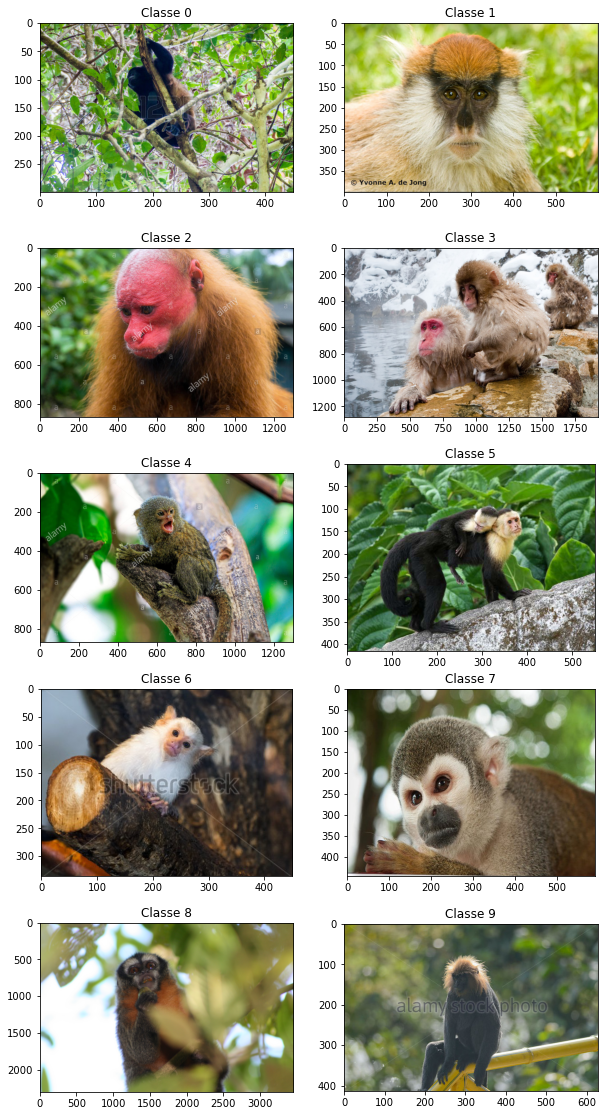

In [4]:
# On affiche une image de chaque classe

df['label']=df['label'].astype('int')

plt.figure(figsize=(10,20))
j = 1

for i in range(len(df.label.value_counts().index)):
    
    plt.subplot(5,2,j)
    j = j+1
    a = random.randint(1,10)
    plt.imshow(img.imread(df[df['label']==i].reset_index().loc[a,'path']))
    plt.title(f'Classe {i}')
    
plt.show()    
    


En observant ces images, il semble pertinent, en première approche, de considérer que la couleur va être un élément déterminant pour la caractérisation de certaines espèces qui présentent peu de différences de morphologie.

In [5]:
# Combien d'image pour l'entrainement ?
len(df[df['jeu']=='training'])

1098

Il conviendra assurément de procéder à l'augmentation de donnée afin d'entrainer correctement le modèle

# -----------------------------------------------------------------------------------------------------------

### Essai traitement d'image <a class="anchor" id="chapter4"></a>

* [retour Table](#chapter0)

On définit un ensemble de fonction de traitement d'image

In [37]:
# On convertit l'image en niveau de gris   
def gris(image):
    
    image2 = image.copy()
    
    # On ramène l'image à un vecteur à une seule dimension
    image2 = image2.reshape(75*75*3)

    # On recupère chaque canal
    canal_0 = image2[0::3]
    canal_1 = image2[1::3]
    canal_2 = image2[2::3]

    # On crée un vecteur des moyennes de chaque canal
    moyenne = canal_0.copy() # on récupère la size du vecteur
    i = np.arange(0,(len(moyenne)))
    moyenne[i]=(canal_0[i]+canal_1[i]+canal_2[i])/3
    
    # On recupère la size du vecteur
    image_final = image2.copy()

    # On prépare la liste d'indice

    d = np.arange(0,5625)

    # On remplace les valeur de chaque canal d'un pixel donné par la moyenne des canaux pour chaque pixel considéré
    image_final[0::3][d] = moyenne[d]
    image_final[1::3][d] = moyenne[d]
    image_final[2::3][d] = moyenne[d]

    image_final = image_final.reshape(75,75,3)
    
    return image_final

# On réduit le nombre de nuance RGB possible -> 729 nuances
def color_simplier(source):
    source_color = source.copy()
    source_color = source_color.reshape(75*75*3)
    source_color = (source_color*10).astype(int)*0.1
    source_color = source_color.reshape(75,75,3)
    
    return source_color

# On réduit davantage encore le nombre de nuance RGB possible -> 27 nuances 

def color_simpliest(source):
    source_color = source.copy()
    
    source_color_plat = source_color.reshape(75*75*3)
    
    # On prépare les array de filtration
    source_box_1 = source_color_plat.copy()
    source_box_2 = source_color_plat.copy()
    source_box_3 = source_color_plat.copy()
    
    # On filtre en fonction d'une valeur donnée
    source_box_1 = np.where(source_box_1<=0.3,0.3,0)
    source_box_2 = np.where((source_box_2>0.3)&(source_box_2 <=0.6),0.6,0)
    source_box_3 = np.where(source_box_3>0.6,0.9,0)
    
    # On rebati le vecteur image filtré
    source_color_plat = source_box_1 + source_box_2 + source_box_3
    
    source_color = source_color_plat.reshape(75,75,3)
                    
                             
    return source_color

# On définit une fonction permettant d'ajouter un bruit gaussien à l'image

def aleaGauss(sigma):
    a = random.random()
    b = random.random()
    return sigma*np.sqrt(-2*np.log(a))*np.cos(2*np.pi*b) 

def bruitGaussien(image):
    brlln = image.copy()
    brlln = brlln.reshape(75*75*3)

    canal_r = brlln[0::3]
    canal_g = brlln[1::3]
    canal_b = brlln[2::3]

    sigma_r = canal_r.std()
    

    i = np.arange(0,len(canal_r),1)
    canal_r[i] = canal_r[i]+aleaGauss(sigma_r)*0.1
    canal_r = np.where(canal_r<0,0,canal_r)
    canal_r = np.where(canal_r>=1,1,canal_r)

    final = brlln.copy()
    final[0::3][i]=canal_r[i]
    final[1::3][i]=canal_g[i]
    final[2::3][i]=canal_b[i]

    final = final.reshape(75,75,3)
    
    return final

# On définit une fonction permettant d'augmenter la luminance

def lumi_plus(image,x):
    
    brlln = image.copy()
    brlln = brlln.reshape(75*75*3)
    
    final = brlln*x
    final = final.reshape(75,75,3)
    return final

# On définit une fonction permettant de diminuer la luminance

def lumi_moins(image,x):
    
    brlln = image.copy()
    brlln = brlln.reshape(75*75*3)
    
    final = brlln*x
    final = final.reshape(75,75,3)
    return final



On affiche le résultat de ces traitements

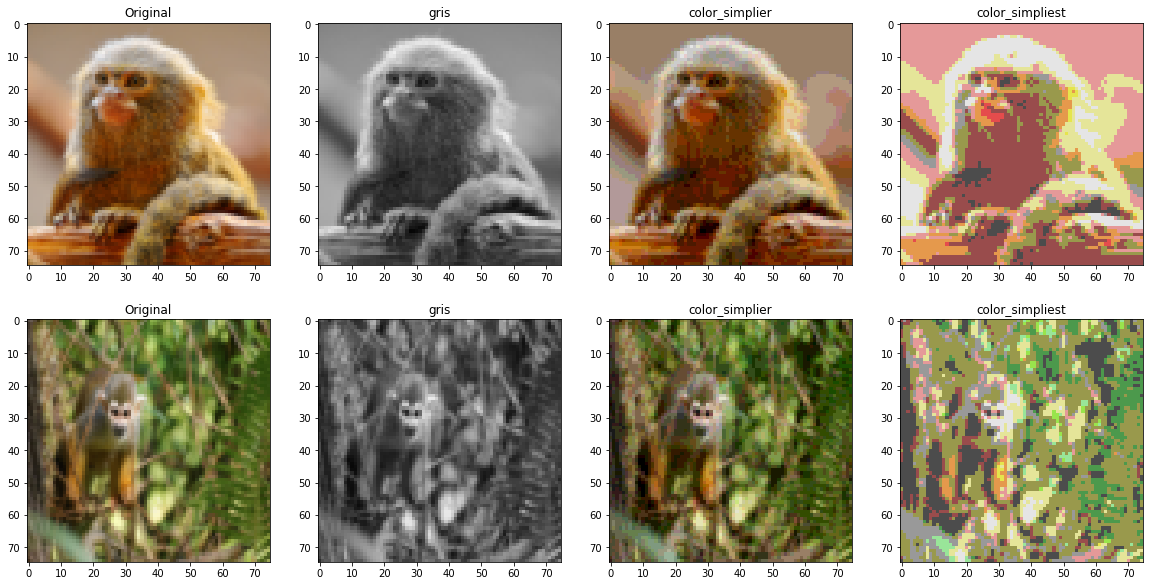

In [7]:
def affiche():

    plt.figure(figsize=(20,10))

    image1 = transform.resize(np.asarray(Image.open(df.loc[502,'path'])),(75,75))
    image2 = transform.resize(np.asarray(Image.open(df.loc[880,'path'])),(75,75))

    plt.subplot(2,4,1)
    plt.imshow(image1)
    plt.title('Original')

    plt.subplot(2,4,2)
    plt.imshow(gris(image1))
    plt.title('gris')

    plt.subplot(2,4,3)
    plt.imshow(color_simplier(image1))
    plt.title('color_simplier')

    plt.subplot(2,4,4)
    plt.imshow(color_simpliest(image1))
    plt.title('color_simpliest')


    plt.subplot(2,4,5)
    plt.imshow(image2)
    plt.title('Original')

    plt.subplot(2,4,6)
    plt.imshow(gris(image2))
    plt.title('gris')

    plt.subplot(2,4,7)
    plt.imshow(color_simplier(image2))
    plt.title('color_simplier')

    plt.subplot(2,4,8)
    plt.imshow(color_simpliest(image2))
    plt.title('color_simpliest')

    plt.show()
    
affiche()

On a convenu que la couleur est un élement important dans la classification d'espèces présentant des similitudes morphologiques marquées. Mais il n'est peut-être pas nécessaire d'avoir un fort nuancier de couleurs et il peut être interessant de réduire ce nombre sur des images 300x300. En deça et notamment sur les images 75x75 présentées ci-dessus, de tels traitement d'image semblent de prime abord contre-productif

# -----------------------------------------------------------------------------------------------------------

## Setup du modèle <a class="anchor" id="chapter8"></a>

* [retour table](#chapter0)

On crée les fonctions de generation de modèle et d'affichage des courbes d'accuracy

In [8]:
def get_model(dim1,dim2,dim3):
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(dim1,dim2,dim3)))
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(LeakyReLU())

    model.add(Dropout(0.4))

    model.add(Dense(10, activation='softmax'))
    
    return model

In [76]:
def plot_acc(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['train','test'],loc='lower right')

###  Modèle convolutif avec generator et augmentation de données <a class="anchor" id="chapter5"></a>

* [retour Table](#chapter0)

On ramène les images aux dimensions suivantes: 

In [10]:
dim_1 = 75
dim_2 = 75

In [11]:

df['array_resized'] = df.path.swifter.apply(lambda x :transform.resize(np.asarray(Image.open(x)),(dim_1,dim_2)))

Pandas Apply:   0%|          | 0/1370 [00:00<?, ?it/s]

On crée une fonction qui permet d'enregistrer les images dans des répertoires dédiés, en nommant chaque image avec les variables pertinentes du dataframe d'exploration:
- training ou validation
- la classe ("label")
- l'id unique de la photo

In [12]:

def save_image(path,x):
    plt.axis('off')
    plt.imshow(df.loc[x,'array_resized']);
    os.chdir(path)
    plt.savefig(f"{df.loc[x,'jeu']}_{df.loc[x,'label']}_{df.loc[x,'id']}",dpi=300)

On définit les répertoires d'enregistrement

In [13]:
path_train = 'D:\BAZAR-Lolo\singe_data_train'
path_test = 'D:\BAZAR-Lolo\singe_data_test'

On procède à l'enregistrement des images dans les répertoires:

In [14]:
'''
for i in df[df['jeu']=='training'].index:
    save_image(path_train,i)
    

#for i in df[df['jeu']=='validation'].index:
    #save_image(path_test,i)
'''

"\nfor i in df[df['jeu']=='training'].index:\n    save_image(path_train,i)\n    \n\n#for i in df[df['jeu']=='validation'].index:\n    #save_image(path_test,i)\n"

On prépare le generator par la création des datasets associés aux dossiers précédemment remplis:

In [58]:
# On parcours le dossier train et on stocke les chemins dans une liste:
fichiers_train =[]    
for root,dirs,files in os.walk(path_train):
    for fichier in files:
        fichiers_train.append(os.path.join(root,fichier))

# On crée un dataframe à partir de la liste précédente:
data_train = pd.DataFrame(fichiers_train,columns =['path_train'])

# On crée une variable label à partir du path:
data_train['label'] = data_train.path_train.apply(lambda x : x.split('_')[3])

# On réitère la démarche pour le dossier test:
fichiers_test =[]    
for root,dirs,files in os.walk(path_test):
    for fichier in files:
        fichiers_test.append(os.path.join(root,fichier))

data_test = pd.DataFrame(fichiers_test,columns =['path_test'])
data_test['label'] = data_test.path_test.apply(lambda x : x.split('_')[3])

On procède à la création du generator

In [59]:
# On réalise l'augmentation de données
train_data_generator = ImageDataGenerator(rescale=1. / 255,
                        rotation_range = 10,
                        width_shift_range = 10,
                        height_shift_range = 0.1,
                        zoom_range = 1.1,
                        horizontal_flip = True)

test_data_generator = ImageDataGenerator(rescale=1. / 255)

In [67]:
batch_size = 12

train_generator = train_data_generator.flow_from_dataframe(directory = 'D:\BAZAR-Lolo\singe_data_train',
                                                           dataframe = data_train,
                                                          class_mode ='sparse',
                                                          x_col ='path_train',
                                                           y_col ='label',
                                                          target_size=(dim_1,dim_2),
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(directory = 'D:\BAZAR-Lolo\singe_data_test',
                                                         dataframe = data_test,
                                                          class_mode ='sparse',
                                                          x_col ='path_test',
                                                           y_col ='label',
                                                          target_size=(dim_1,dim_2),
                                                          batch_size = batch_size)

Found 1098 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


On crée un modèle convolutif

In [68]:
model1 = get_model(dim_1,dim_2,3)
epok1 =30
batch_size1 = 12

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [69]:
# On entraine ce modèle avec le generator
history = model1.fit_generator(generator=train_generator,
                    steps_per_epoch = len(data_train)//batch_size1,
                    validation_data=test_generator,
                    validation_steps = len(data_test)//batch_size1,
                    epochs=epok1)

Epoch 1/30
91/91 [==============================] - 69s 752ms/step - loss: 2.3650 - accuracy: 0.1363 - val_loss: 2.0366 - val_accuracy: 0.2348
Epoch 2/30
91/91 [==============================] - 69s 755ms/step - loss: 2.1255 - accuracy: 0.2348 - val_loss: 1.9046 - val_accuracy: 0.2879
Epoch 3/30
91/91 [==============================] - 66s 729ms/step - loss: 1.9921 - accuracy: 0.2983 - val_loss: 1.9770 - val_accuracy: 0.2652
Epoch 4/30
91/91 [==============================] - 67s 739ms/step - loss: 1.9635 - accuracy: 0.2873 - val_loss: 1.6303 - val_accuracy: 0.4015
Epoch 5/30
91/91 [==============================] - 67s 741ms/step - loss: 1.8350 - accuracy: 0.3269 - val_loss: 1.7400 - val_accuracy: 0.3712
Epoch 6/30
91/91 [==============================] - 66s 731ms/step - loss: 1.7591 - accuracy: 0.3600 - val_loss: 1.7123 - val_accuracy: 0.3977
Epoch 7/30
91/91 [==============================] - 67s 740ms/step - loss: 1.7475 - accuracy: 0.3748 - val_loss: 1.5067 - val_accuracy: 0.4545

On affiche l'évolution de la loss et de l'accuracy

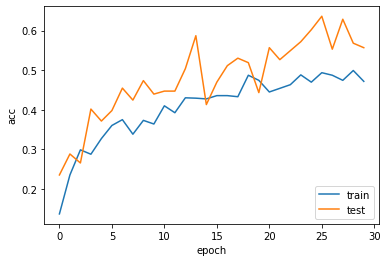

In [77]:
plot_acc(history)

# -----------------------------------------------------------------------------------------------------------

### Modèle convolutif sans generator, sur jeu de données initiales <a class="anchor" id="chapter6"></a>

* [retour Table](#chapter0)

On prépare les données d'entrainement et de test 

In [21]:
x_train_2 =[]

for i in range(len(df[df['jeu']=='training'].array_resized.values)):
    x_train_2.append(df[df['jeu']=='training'].array_resized.values[i])
x_train_2 = np.asarray(x_train_2).reshape(-1,dim_1,dim_2,3)


x_test_2 =[]
for i in range(len(df[df['jeu']=='validation'].array_resized.values)):
    x_test_2.append(df[df['jeu']=='validation'].array_resized.values[i])
x_test_2 = np.asarray(x_test_2).reshape(-1,dim_1,dim_2,3)

y_train_2 = df[df['jeu']=='training'].label.values
y_test_2 = df[df['jeu']=='validation'].label.values

print(f'shape de x_train_2 : {x_train_2.shape}')
print(f'shape de x_test_2 : {x_test_2.shape}')
print(f'shape de y_train_2 : {y_train_2.shape}')
print(f'shape de y_test_2 : {y_test_2.shape}')

shape de x_train_2 : (1098, 75, 75, 3)
shape de x_test_2 : (272, 75, 75, 3)
shape de y_train_2 : (1098,)
shape de y_test_2 : (272,)


In [22]:
# On entraine notre nouveau model sans le generator
model2 = get_model(dim_1,dim_2,3)
epok2 =10
batch_size2 = 12

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

training_history2 = model2.fit(x_train_2,y_train_2,batch_size = 12,epochs=epok2,validation_data=(x_test_2,y_test_2))

Epoch 1/10
92/92 [==============================] - 27s 281ms/step - loss: 2.0431 - accuracy: 0.2732 - val_loss: 1.6222 - val_accuracy: 0.3860
Epoch 2/10
92/92 [==============================] - 26s 278ms/step - loss: 1.4017 - accuracy: 0.5146 - val_loss: 1.4359 - val_accuracy: 0.4963
Epoch 3/10
92/92 [==============================] - 26s 278ms/step - loss: 1.2392 - accuracy: 0.5719 - val_loss: 1.2618 - val_accuracy: 0.5846
Epoch 4/10
92/92 [==============================] - 26s 280ms/step - loss: 1.0331 - accuracy: 0.6512 - val_loss: 1.2795 - val_accuracy: 0.5257
Epoch 5/10
92/92 [==============================] - 26s 283ms/step - loss: 0.8151 - accuracy: 0.7250 - val_loss: 1.0869 - val_accuracy: 0.6728
Epoch 6/10
92/92 [==============================] - 26s 278ms/step - loss: 0.6339 - accuracy: 0.7987 - val_loss: 1.1288 - val_accuracy: 0.6507
Epoch 7/10
92/92 [==============================] - 26s 278ms/step - loss: 0.5340 - accuracy: 0.8297 - val_loss: 1.2505 - val_accuracy: 0.6471

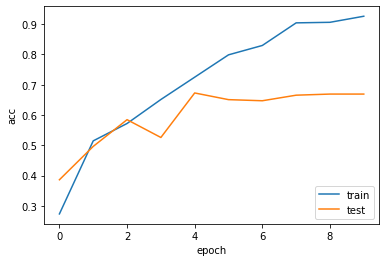

In [78]:
# On affiche l'évolution de l'accuracy

plot_acc(training_history2)

# -----------------------------------------------------------------------------------------------------------

## Modèle convolutif avec augmentation de donnée sur dataframe <a class="anchor" id="chapter7"></a>

* [retour Table](#chapter0)

### Augmentation de donnée sur dataframe <a class="anchor" id="section_7_1"></a>

On crée plusieurs fonction destinées à augmenter le volume de donnée

In [24]:
# La fonction qui retourne horizontalement l'image:

def reverse(image):
    a = image.shape[1]-1
    i = np.arange(a,0,-1)
    j = np.arange(0,a,1)
    reverse = image.copy()
    if len(image.shape) >2:
        reverse[:,i,:]= image[:,j,:]
    else :
        reverse[:,i]= image[:,j]
    return reverse

# La fonction qui retourne verticalement l'image:

def up_down(image):
    a = image.shape[1]-1
    i = np.arange(a,0,-1)
    j = np.arange(0,a,1)
    reverse = image.copy()
    if len(image.shape) >2:
        reverse[i,:,:]= image[j,:,:]
    else:
        reverse[:,i]= image[:,j]
    return reverse

# La fonction qui combine les deux transformations précédantes:

def reverse_up_down(image):
    a = image.shape[1]-1
    i = np.arange(a,0,-1)
    j = np.arange(0,a,1)
    reverse = image.copy()
    
    if len(image.shape) >2:
        reverse[i,:,:]= image[j,:,:]
        reverse[:,i,:]= reverse[:,j,:]
    else:
        reverse[i,:]= image[j,:]
        reverse[:,i]= reverse[:,j]
    return reverse

# La fonction qui décale l'image à droite:

def decalage_droite(image):
    image_decalee = image.copy()
    k = np.arange(0,3,1)
    image_decalee[:,:,k]=0
    image_decalee[:,50:75]= image[:,25:50] 
    return image_decalee
    
# La fonction qui décale l'image à gauche:    
    
def decalage_gauche(image):
    image_decalee = image.copy()
    k = np.arange(0,3,1)
    image_decalee[:,:,k]=0
    image_decalee[:,0:30]= image[:,20:50]   
    return image_decalee





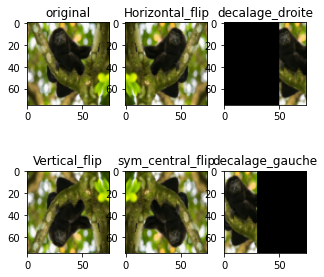

In [25]:
#illustration des transformatiosn proposées:

plt.figure(figsize=(5,5))

plt.subplot(2,3,1)
plt.imshow(df.array_resized[5])
plt.title('original')

plt.subplot(2,3,2)
plt.imshow(reverse(df.array_resized[5]))
plt.title('Horizontal_flip')

plt.subplot(2,3,4)
plt.imshow(up_down(df.array_resized[5]))
plt.title('Vertical_flip')

plt.subplot(2,3,5)
plt.imshow(reverse_up_down(df.array_resized[5]))
plt.title('sym_central_flip')

plt.subplot(2,3,3)
plt.imshow(decalage_droite(df.array_resized[5]))
plt.title('decalage_droite')

plt.subplot(2,3,6)
plt.imshow(decalage_gauche(df.array_resized[5]))
plt.title('decalage_gauche')


plt.show()

On produit une dataframe qui servira de support à l'application de ces transformations:

In [38]:
essai = df[['label','jeu','array_resized']].copy()


On veille à n'appliquer l'augmentation de donnée que sur les images d'entrainement

In [39]:
# On crée un dataset de test
keep = essai[essai['jeu']=='validation']

# On épure le dataset d'entrainement
to_suppr = essai[essai['jeu']=='validation'].index
essai = essai.drop(to_suppr)

On applique le retournement horizontal; Les autres transformées peuvent induire en erreur le modèle dans la mesure où le fond de l'image est également retourné, ce qui ne présente pas de réalité concrète

In [40]:

essai['horizontal_flip']=essai.array_resized.apply(lambda x : reverse(x))
essai['decalage_droite']=essai.array_resized.apply(lambda x : decalage_droite(x))
essai['decalage_gauche']=essai.array_resized.apply(lambda x : decalage_gauche(x))
essai['h_flip_decalage_droite']=essai.horizontal_flip.apply(lambda x : decalage_droite(x))
essai['h_flip_decalage_gauche']=essai.horizontal_flip.apply(lambda x : decalage_gauche(x))


On rebâtit une unique dataframe

In [41]:

temp = pd.concat([essai[['label','jeu','array_resized']],
                   essai[['label','jeu','horizontal_flip']].rename(columns ={'horizontal_flip':'array_resized'}),
                   essai[['label','jeu','decalage_droite']].rename(columns ={'decalage_droite':'array_resized'}),
                   essai[['label','jeu','decalage_gauche']].rename(columns ={'decalage_gauche':'array_resized'}),
                   essai[['label','jeu','h_flip_decalage_droite']].rename(columns ={'h_flip_decalage_droite':'array_resized'}),
                   essai[['label','jeu','h_flip_decalage_gauche']].rename(columns ={'h_flip_decalage_gauche':'array_resized'})
                  ],axis = 0).reset_index().drop(['index'],axis = 1)
                  
            


In [42]:
temp['array_resized_gauss']=temp.array_resized.apply(lambda x : bruitGaussien(x))
temp['array_resized_lumi_plusA']=temp.array_resized.apply(lambda x : lumi_plus(x,1.1))
temp['array_resized_lumi_plusB']=temp.array_resized.apply(lambda x : lumi_plus(x,1.3))
temp['array_resized_lumi_moinsA']=temp.array_resized.apply(lambda x : lumi_moins(x,0.9))
temp['array_resized_lumi_moinsB']=temp.array_resized.apply(lambda x : lumi_moins(x,0.7))

In [43]:
ESSAI = pd.concat([temp[['label','jeu','array_resized']],
                   temp[['label','jeu','array_resized_gauss']].rename(columns ={'array_resized_gauss':'array_resized'}),
                   temp[['label','jeu','array_resized_lumi_plusA']].rename(columns ={'array_resized_lumi_plusA':'array_resized'}),
                   temp[['label','jeu','array_resized_lumi_moinsA']].rename(columns ={'array_resized_lumi_moinsA':'array_resized'}),
                   temp[['label','jeu','array_resized_lumi_plusB']].rename(columns ={'array_resized_lumi_plusB':'array_resized'}),
                   temp[['label','jeu','array_resized_lumi_moinsB']].rename(columns ={'array_resized_lumi_moinsB':'array_resized'}),
                  keep],axis = 0).reset_index().drop(['index'],axis = 1)

In [32]:
ESSAI.head(2)

,label,jeu,array_resized
0,0,training,"[[[0.4085315904139437, 0.3930544662309374, 0.1..."
1,0,training,"[[[0.5160784313725508, 0.5885882352941183, 0.1..."


On cherche à voir l'impact de la couleur sur la performance du modèle

In [33]:
#ESSAI['array_resized_gris'] = ESSAI.array_resized.apply(lambda x : gris(x))
#ESSAI['array_resized_simplier'] = ESSAI.array_resized.apply(lambda x : color_simplier(x))


In [34]:
ESSAI.label = ESSAI.label.astype('int')

## Modèle convolutif <a class="anchor" id="section_7_2"></a>

* [retour Table](#chapter0)

On prépare les données d'entrainement et de test pour le jeu augmenté 

In [44]:
x_train_3 =[]

for i in range(len(ESSAI[ESSAI['jeu']=='training'].array_resized.values)):
    x_train_3.append(ESSAI[ESSAI['jeu']=='training'].array_resized.values[i])
x_train_3 = np.asarray(x_train_3).reshape(-1,dim_1,dim_2,3)


x_test_3 =[]
for i in range(len(ESSAI[ESSAI['jeu']=='validation'].array_resized.values)):
    x_test_3.append(ESSAI[ESSAI['jeu']=='validation'].array_resized.values[i])
x_test_3 = np.asarray(x_test_3).reshape(-1,dim_1,dim_2,3)

y_train_3 = ESSAI[ESSAI['jeu']=='training'].label.values
y_test_3 = ESSAI[ESSAI['jeu']=='validation'].label.values

print(f'shape de x_train_3 : {x_train_3.shape}')
print(f'shape de x_test_3 : {x_test_3.shape}')
print(f'shape de y_train_3 : {y_train_3.shape}')
print(f'shape de y_test_3 : {y_test_3.shape}')

shape de x_train_3 : (39528, 75, 75, 3)
shape de x_test_3 : (272, 75, 75, 3)
shape de y_train_3 : (39528,)
shape de y_test_3 : (272,)


on instancie et on entraine un nouveau modèle

In [45]:
model3 = get_model(dim_1,dim_2,3)

epok3 =10
batch_size3 = 24
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

training_history3 = model3.fit(x_train_3,y_train_3,batch_size = batch_size3,epochs=epok3,validation_data=(x_test_3,y_test_3))

Epoch 1/10
1647/1647 [==============================] - 1092s 662ms/step - loss: 0.8449 - accuracy: 0.7105 - val_loss: 1.6888 - val_accuracy: 0.7353
Epoch 2/10
1647/1647 [==============================] - 829s 504ms/step - loss: 0.2509 - accuracy: 0.9236 - val_loss: 2.2678 - val_accuracy: 0.7169
Epoch 3/10
1647/1647 [==============================] - 853s 518ms/step - loss: 0.2146 - accuracy: 0.9406 - val_loss: 3.4422 - val_accuracy: 0.7243
Epoch 4/10
1647/1647 [==============================] - 839s 509ms/step - loss: 0.1873 - accuracy: 0.9548 - val_loss: 4.2110 - val_accuracy: 0.7279
Epoch 5/10
1647/1647 [==============================] - 828s 503ms/step - loss: 0.2311 - accuracy: 0.9527 - val_loss: 4.8736 - val_accuracy: 0.7353
Epoch 6/10
1647/1647 [==============================] - 813s 494ms/step - loss: 0.1962 - accuracy: 0.9636 - val_loss: 5.8031 - val_accuracy: 0.7022
Epoch 7/10
1647/1647 [==============================] - 834s 506ms/step - loss: 0.2525 - accuracy: 0.9597 - val

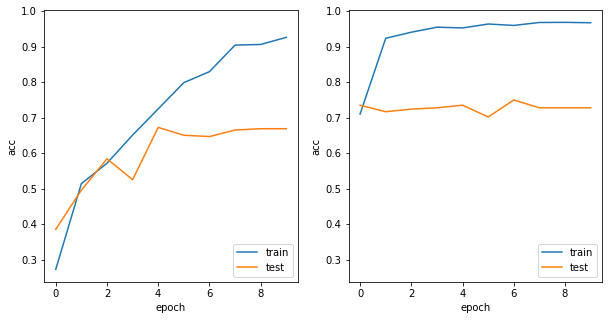

In [79]:
# On affiche l'évolution de la loss et de l'accuracy

plt.figure(figsize=(10,5))
ax0=plt.subplot(1,2,1)
plot_acc(training_history2)

ax1 = plt.subplot(122,sharey=ax0)
plot_acc(training_history3)
plt.show()


L'entrainement sur données augmentées (graphique de droite) permet d'atteindre plus rapidement un plateau, légèrement plus élevé que sur l'entrainement utilisant les données originelles.

On produit la prédiction des classes à partir du X_test

In [48]:
y_softmax = model3.predict(x_test_3)
y_pred = np.argmax(y_softmax,axis = -1)
    

On affiche la matrice de confusion

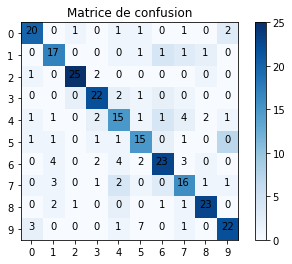

In [49]:
cnf_matrix = confusion_matrix(y_test_3,y_pred)

classes = range(0,10)

plt.figure()
plt.imshow(cnf_matrix,interpolation ='nearest',cmap = 'Blues')
plt.title('Matrice de confusion')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks,classes)
plt.yticks(tick_marks,classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(i,j,cnf_matrix[i,j],horizontalalignment ='center')
        
plt.show()

On affiche quelques erreurs de prédictions

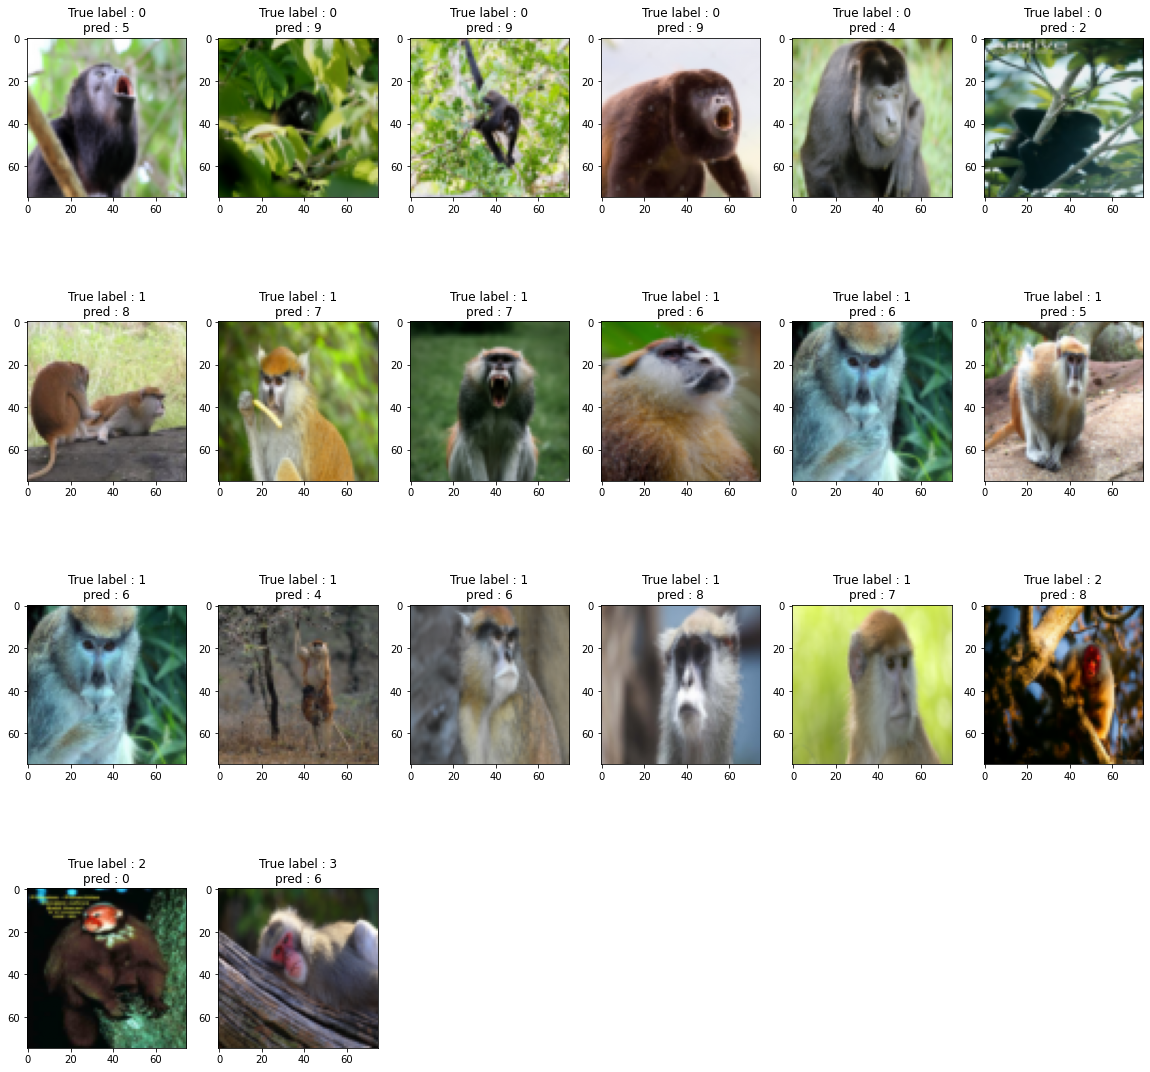

In [50]:
error = []

for i in range(len(y_pred)):
    if y_test_3[i] != y_pred[i]:
        error.append(i)
        
plt.figure(figsize=(20,20))

j = 1
for i in error[0:20]:
    img = x_test_3[i]
    img = img.reshape(dim_1,dim_2,3)
    
    plt.subplot(4,6,j)
    j = j+1
   
    plt.imshow(img)
    
    plt.title(f'True label : {str(y_test_3[i])}' + '\n' + f'pred : {str(y_pred[i])}')

* [retour Table](#chapter0)

# -----------------------------------------------------------------------------------------------------------

## Pour mémoire

- Quelques fonctions de traitement d'images

In [ ]:
def RGB_hist_equal(image):
    hsv = color.rgb2hsv(image)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    new = color.hsv2rgb(hsv)
    return new

def Gray_hist_equal(image):
    image=color.rgb2gray(image)
    new=exposure.equalize_hist(image)
    return new

def Gray_local_hist_equal(image):
    img=color.rgb2gray(image)
    img = img_as_ubyte(img)
    img=rank.equalize(img, disk(10))/255.
    return img

def Gray_contrast(image):
    img=color.rgb2gray(image)
    img=exposure.equalize_adapthist(img)
    return img

def Gray(image):
    img=color.rgb2gray(image)
    return img
    
def Gray_Edges(image):
    edges = filters.sobel(Gray(image))
    return edges

def filtre_custom(image):
    thresh = image.max()
    return image*thresh